# Understanding KL-Divergence

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

### Goals:



#### G1: Given probability distributions $p$ and $q$, find the divergence (measure of similarity) between them

Let us first look at G1. Look at the illustration below. We have a normal distribution $p$ and two other normal distributions $q_1$ and $q_2$. Which of $q_1$ and $q_2$, would we consider closer to $p$? $q_2$, right? 

![](dkl.png)

To understand the notion of similarity, we use a metric called the KL-divergence given as $D_{KL}(a || b)$ where $a$ and $b$ are the two distributions. 

For G1, we can say $q_2$ is closer to $p$ compared to $q_1$ as:

$D_{KL}(q_2 || p) \lt D_{KL}(q_1 || p)$

For the above example, we have the values as $D_{KL}(q_2|| p) = 0.07$ and $D_{KL}(q_1|| p)= 0.35$

#### G2: assuming $p$ to be fixed, can we find optimum parameters of $q$ to make it as close as possible to $p$

The following GIF shows the process of finding the optimum set of parameters for a normal distribution $q$ so that it becomes as close as possible to $p$. This is equivalent of minimizing $D_{KL}(q || p)$


![](kl_qp.gif)

The following GIF shows the above but for a two-dimensional distribution.


![](kl_qp_2.gif)

#### G3: finding the "distance" between two distributions of different families


The below image shows the KL-divergence between distribution 1 (mixture of Gaussians) and distribution 2 (Gaussian)

![](dkl-different.png)


#### G4: optimizing the "distance" between two distributions of different families

The below GIF shows the optimization of the KL-divergence between distribution 1 (mixture of Gaussians) and distribution 2 (Gaussian)

![](kl_qp_mg.gif)


#### G5: Approximating the KL-divergence

#### G6: Implementing variational inference for linear regression




### Basic Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow_probability as tfp
import pandas as pd

tfd = tfp.distributions
tfl = tfp.layers
tfb = tfp.bijectors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Creating distributions

#### Creating $p\sim\mathcal{N}(1.00, 4.00)$

In [2]:
p = tfd.Normal(1, 4)

2022-02-04 14:55:14.596076: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


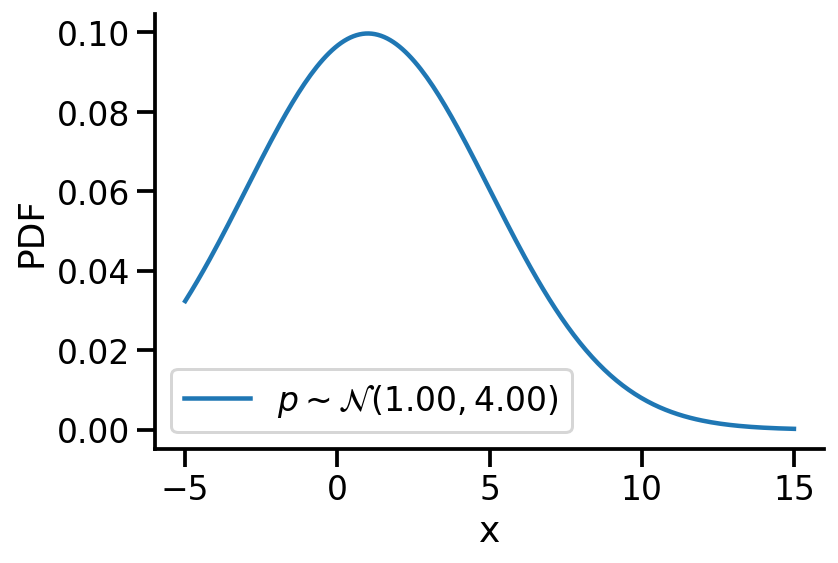

In [3]:
z_values = tf.linspace(-5, 15, 200)
z_values = tf.cast(z_values, tf.float32)
prob_values_p = p.prob(z_values)
plt.plot(z_values, prob_values_p, label=r"$p\sim\mathcal{N}(1.00, 4.00)$")
sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF")

#### Creating $q\sim\mathcal{N}(loc, scale)$

In [4]:
def create_q(loc, scale):
    return tfd.Normal(loc, scale)

#### Generating a few qs for different location and scale value

In [5]:
q = {}
q[(0, 1)] = create_q(0.0, 1.0)

for loc in [0, 1]:
    for scale in [1, 2]:
        q[(loc, scale)] = create_q(float(loc), float(scale))

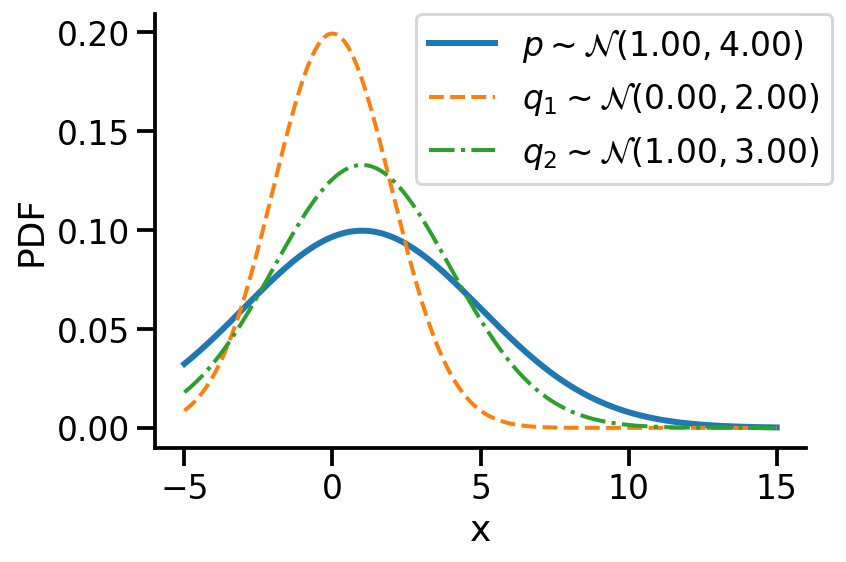

In [6]:
plt.plot(z_values, prob_values_p, label=r"$p\sim\mathcal{N}(1.00, 4.00)$", lw=3)
plt.plot(
    z_values,
    create_q(0.0, 2.0).prob(z_values),
    label=r"$q_1\sim\mathcal{N}(0.00, 2.00)$",
    lw=2,
    linestyle="--",
)
plt.plot(
    z_values,
    create_q(1.0, 3.0).prob(z_values),
    label=r"$q_2\sim\mathcal{N}(1.00, 3.00)$",
    lw=2,
    linestyle="-.",
)

plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.xlabel("x")
plt.ylabel("PDF")
sns.despine()
plt.tight_layout()
plt.savefig(
    "dkl.png",
    dpi=150,
)

In [7]:
#### Computing KL-divergence

q_0_2_dkl = tfd.kl_divergence(create_q(0.0, 2.0), p)
q_1_3_dkl = tfd.kl_divergence(create_q(1.0, 3.0), p)

print(f"D_KL (q(0, 2)||p) = {q_0_2_dkl:0.2f}")
print(f"D_KL (q(1, 3)||p) = {q_1_3_dkl:0.2f}")

D_KL (q(0, 2)||p) = 0.35
D_KL (q(1, 3)||p) = 0.07


As mentioned earlier, clearly, $q_2\sim\mathcal{N}(1.00, 3.00)$ seems closer to $p$

### Optimizing the KL-divergence between q and p

We could create a grid of (loc, scale) pairs and find the best, as shown below.

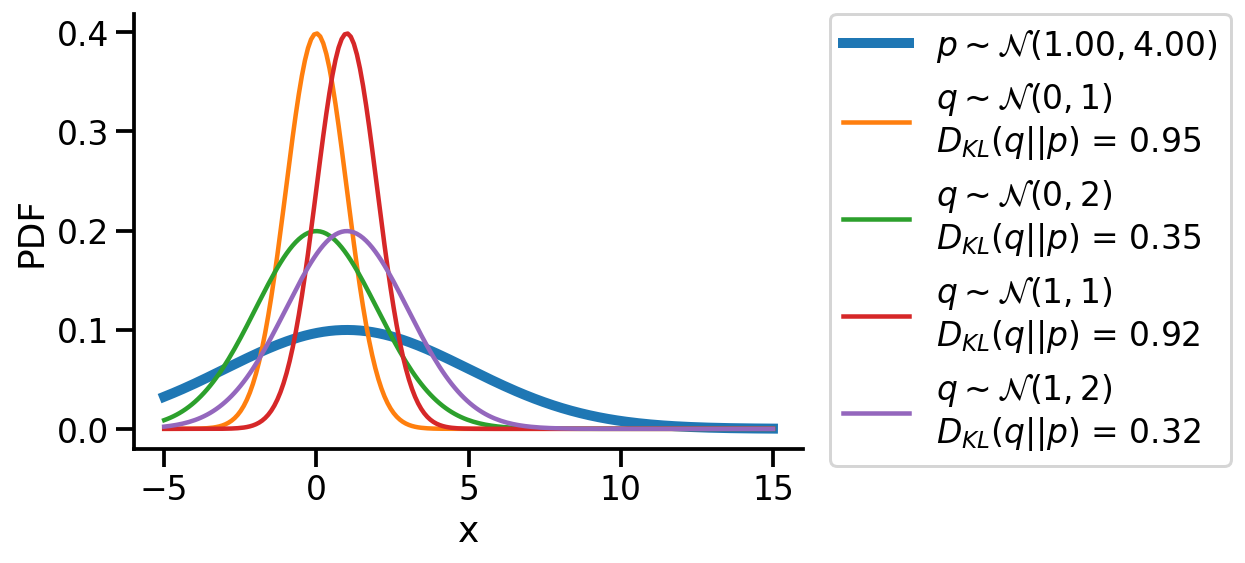

In [8]:
plt.plot(z_values, prob_values_p, label=r"$p\sim\mathcal{N}(1.00, 4.00)$", lw=5)


for loc in [0, 1]:
    for scale in [1, 2]:
        q_d = q[(loc, scale)]
        kl_d = tfd.kl_divergence(q[(loc, scale)], p)
        plt.plot(
            z_values,
            q_d.prob(z_values),
            label=rf"$q\sim\mathcal{{N}}({loc}, {scale})$"
            + "\n"
            + rf"$D_{{KL}}(q||p)$ = {kl_d:0.2f}",
        )
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.xlabel("x")
plt.ylabel("PDF")
sns.despine()

Or, we could use continuous optimization to find the best loc and scale parameters for q.

In [9]:
to_train_q = tfd.Normal(
    loc=tf.Variable(-1.0, name="loc"),
    scale=tfp.util.TransformedVariable(1.0, bijector=tfb.Exp(), name="scale"),
)

In [10]:
to_train_q.trainable_variables

2022-02-04 14:55:19.564807: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=-1.0>,
 <tf.Variable 'scale:0' shape=() dtype=float32, numpy=0.0>)

In [11]:
@tf.function
def loss_and_grads(q_dist):
    with tf.GradientTape() as tape:
        loss = tfd.kl_divergence(q_dist, p)
    return loss, tape.gradient(loss, q_dist.trainable_variables)

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

for i in range(500):
    loss, grads = loss_and_grads(to_train_q)
    optimizer.apply_gradients(zip(grads, to_train_q.trainable_variables))

In [13]:
to_train_q.loc, to_train_q.scale

(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=0.98873746>,
 <TransformedVariable: name=scale, dtype=float32, shape=[], fn="exp", numpy=3.9999995>)

After training, we are able to recover the scale and loc very close to that of $p$

### Animation!

In [14]:
from matplotlib import animation

fig = plt.figure(tight_layout=True, figsize=(8, 4))
ax = fig.gca()

to_train_q = tfd.Normal(
    loc=tf.Variable(5.0, name="loc"),
    scale=tfp.util.TransformedVariable(0.1, bijector=tfb.Exp(), name="scale"),
)


def animate(i):
    ax.clear()
    ax.plot(z_values, prob_values_p, label=r"$p\sim\mathcal{N}(1.00, 4.00)$", lw=5)
    loss, grads = loss_and_grads(to_train_q)
    optimizer.apply_gradients(zip(grads, to_train_q.trainable_variables))
    loc = to_train_q.loc.numpy()
    scale = to_train_q.scale.numpy()

    ax.plot(
        z_values,
        to_train_q.prob(z_values),
        label=rf"$q\sim \mathcal{{N}}({loc:0.2f}, {scale:0.2f})$",
    )
    d_kl = tfd.kl_divergence(to_train_q, p)

    ax.set_title(rf"Iteration: {i}, $D_{{KL}}(q||p)$: {d_kl:0.2f}")
    ax.legend(bbox_to_anchor=(1.1, 1), borderaxespad=0)
    ax.set_ylim((0, 1))
    ax.set_xlim((-5, 15))

    ax.set_xlabel("x")
    ax.set_ylabel("PDF")
    sns.despine()


ani = animation.FuncAnimation(fig, animate, frames=150)
plt.close()

In [15]:
ani.save("kl_qp.gif", writer="imagemagick", fps=15, dpi=100)

<Figure size 432x288 with 0 Axes>

![](kl_qp.gif)

### Finding the KL divergence for two distributions from different families

Let us rework our example with `p` coming from  a mixture of Gaussian distribution and `q` being Normal.

In [16]:
p_s = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
    components_distribution=tfd.Normal(
        loc=[-0.2, 1], scale=[0.1, 0.5]  # One for each component.
    ),
)  # And same here.

p_s

<tfp.distributions.MixtureSameFamily 'MixtureSameFamily' batch_shape=[] event_shape=[] dtype=float32>

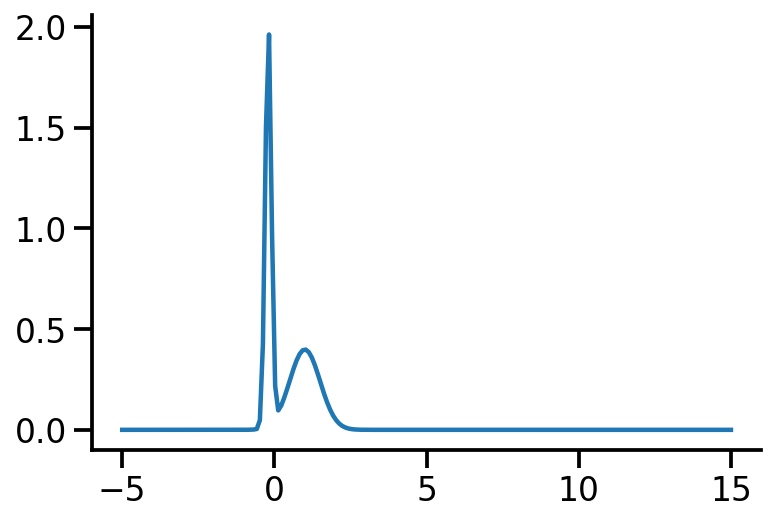

In [17]:
plt.plot(z_values, p_s.prob(z_values))
sns.despine()

Let us create two Normal distributions q_1 and q_2 and plot them to see which looks closer to p_s.

In [18]:
q_1 = create_q(3, 1)
q_2 = create_q(3, 4.5)

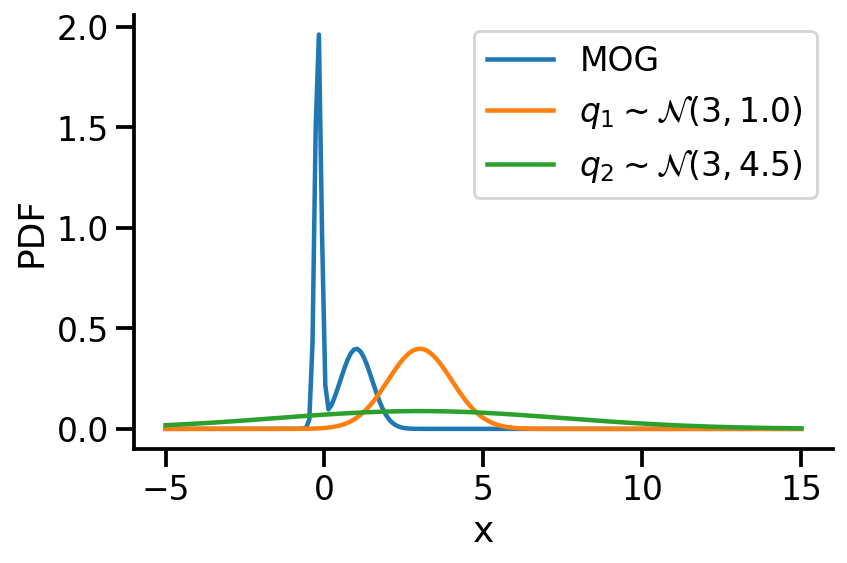

In [19]:
prob_values_p_s = p_s.prob(z_values)
prob_values_q_1 = q_1.prob(z_values)
prob_values_q_2 = q_2.prob(z_values)

plt.plot(z_values, prob_values_p_s, label=r"MOG")
plt.plot(z_values, prob_values_q_1, label=r"$q_1\sim\mathcal{N} (3, 1.0)$")
plt.plot(z_values, prob_values_q_2, label=r"$q_2\sim\mathcal{N} (3, 4.5)$")

sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF")
plt.tight_layout()
plt.savefig(
    "dkl-different.png",
    dpi=150,
)

In [20]:
try:
    tfd.kl_divergence(q_1, p_s)
except Exception as e:
    print(e)

No KL(distribution_a || distribution_b) registered for distribution_a type Normal and distribution_b type MixtureSameFamily


As we see above, we can not compute the KL divergence directly. The core idea would now be to leverage the Monte Carlo sampling and generating the expectation. The following function does that.

In [21]:
def kl_via_sampling(q, p, n_samples=100000):
    # Get samples from q
    sample_set = q.sample(n_samples)
    # Use the definition of KL-divergence
    return tf.reduce_mean(q.log_prob(sample_set) - p.log_prob(sample_set))

In [22]:
kl_via_sampling(q_1, p_s), kl_via_sampling(q_2, p_s)

(<tf.Tensor: shape=(), dtype=float32, numpy=9.465648>,
 <tf.Tensor: shape=(), dtype=float32, numpy=46.48004>)

As we can see from KL divergence calculations, `q_1` is closer to our Gaussian mixture distribution.

### Optimizing the KL divergence for two distributions from different families

We saw that we can calculate the KL divergence between two different distribution families via sampling. But, as we did earlier, will we be able to optimize the parameters of our target surrogate distribution? The answer is No! As we have introduced sampling. However, there is still a way -- by reparameterization! 

Our surrogate q in this case is parameterized by `loc` and `scale`. The key idea here is to generate samples from a standard normal distribution (loc=0, scale=1) and then apply an affine transformation on the generated samples to get the samples generated from q. See my other post on sampling from normal distribution to understand this better.

The loss can now be thought of as a function of `loc` and `scale`.

In [23]:
n_samples = 1000


def loss(loc, scale):
    q = tfd.Normal(loc=loc, scale=scale)
    q_1 = tfd.Normal(loc=0.0, scale=1.0)
    sample_set = q_1.sample(n_samples)
    sample_set = loc + scale * sample_set
    return tf.reduce_mean(q.log_prob(sample_set) - p_s.log_prob(sample_set))

Having defined the loss above, we can now optimize `loc` and `scale` to minimize the KL-divergence.

In [56]:
optimizer = tf.optimizers.Adam(learning_rate=0.05)

In [64]:
n_iter = 150
location_array = np.empty(n_iter, dtype=np.float32)
scale_array = np.empty(n_iter, dtype=np.float32)
loss_array = np.empty(n_iter, dtype=np.float32)


loc = tf.Variable(3.0, dtype=tf.float32)
scale = tf.Variable(4.0, dtype=tf.float32)
for i in range(n_iter):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(loc)
        tape.watch(scale)
        lo = loss(loc, scale)
    [dl_loc, dl_scale] = tape.gradient(lo, [loc, scale])
    if i % 50 == 0:
        tf.print(lo, loc, scale)
    location_array[i] = loc.numpy()
    scale_array[i] = scale.numpy()
    loss_array[i] = lo.numpy()
    optimizer.apply_gradients(zip([dl_loc, dl_scale], [loc, scale]))

38.7589951 3 4
0.4969607 0.736858189 0.680736303
0.528585315 0.774057031 0.617758751


In [65]:
q_s = tfd.Normal(loc=loc, scale=scale)
q_s

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

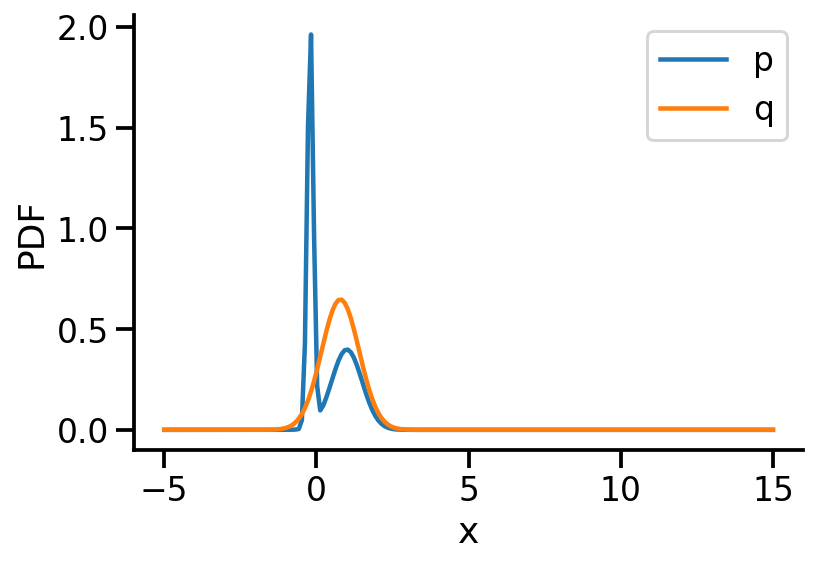

In [66]:
prob_values_p_s = p_s.prob(z_values)
prob_values_q_s = q_s.prob(z_values)

plt.plot(z_values, prob_values_p_s, label=r"p")
plt.plot(z_values, prob_values_q_s, label=r"q")

sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF")

In [70]:
prob_values_p_s = p_s.prob(z_values)

fig = plt.figure(tight_layout=True, figsize=(8, 4))
ax = fig.gca()


def a(iteration):

    ax.clear()
    loc = location_array[iteration]
    scale = scale_array[iteration]
    q_s = tfd.Normal(loc=loc, scale=scale)

    prob_values_q_s = q_s.prob(z_values)

    ax.plot(z_values, prob_values_p_s, label=r"p")
    ax.plot(z_values, prob_values_q_s, label=r"q")
    ax.set_title(f"Iteration {iteration}, Loss: {loss_array[iteration]:0.2f}")


ani_mg = animation.FuncAnimation(fig, a, frames=n_iter)
plt.close()

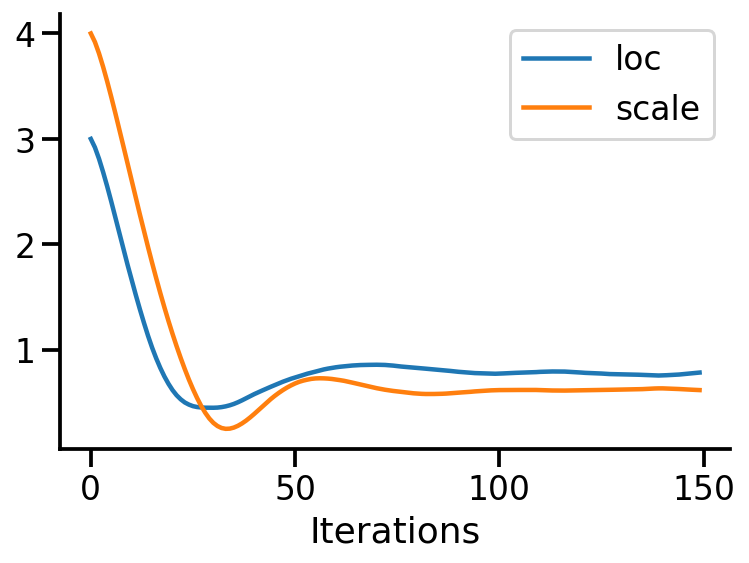

In [71]:
plt.plot(location_array, label="loc")
plt.plot(scale_array, label="scale")
plt.xlabel("Iterations")
sns.despine()
plt.legend()

In [72]:
ani_mg.save("kl_qp_mg.gif", writer="imagemagick")

![](kl_qp_mg.gif)

### Optimizing the KL-divergence between two 2d distributions

Let us now repeat the same procedure but for two 2d Normal distributions. 

In [30]:
p_2d = tfd.MultivariateNormalFullCovariance(
    loc=[0.0, 0.0], covariance_matrix=[[1.0, 0.5], [0.5, 2]]
)

to_train_q_2d_2 = tfd.MultivariateNormalDiag(
    loc=tf.Variable([2.0, -2.0], name="loc"),
    scale_diag=tfp.util.TransformedVariable(
        [1.0, 2.0], bijector=tfb.Exp(), name="scale"
    ),
)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [31]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def make_pdf_2d_gaussian(mu, sigma, ax, title):
    N = 60
    X = np.linspace(-3, 3, N)
    Y = np.linspace(-3, 4, N)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    F = tfd.MultivariateNormalFullCovariance(loc=mu, covariance_matrix=sigma)
    Z = F.prob(pos)

    sns.despine()
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_aspect("equal")
    if title:
        ax.set_title(f"$\mu$ = {mu}\n $\Sigma$ = {np.array(sigma)}")
        ax.contour(X, Y, Z, cmap="viridis", alpha=1, zorder=2)
    else:
        ax.contourf(X, Y, Z, cmap="plasma", alpha=0.1)

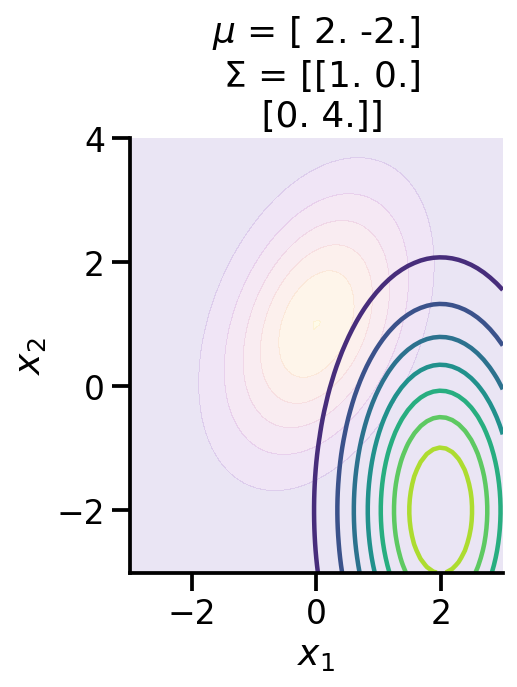

In [32]:
fig, ax = plt.subplots()
make_pdf_2d_gaussian([0.0, 1.0], [[1.0, 0.5], [0.5, 2]], ax, False)
make_pdf_2d_gaussian(
    to_train_q_2d_2.loc.numpy(), to_train_q_2d_2.covariance().numpy(), ax, True
)

As we can see above, the two distributions look very different. We can calculate the KL-divergence as before.

In [33]:
tfd.kl_divergence(to_train_q_2d_2, p_2d)

<tf.Tensor: shape=(), dtype=float32, numpy=4.8723755>

In [34]:
fig = plt.figure(tight_layout=True, figsize=(8, 4))
ax = fig.gca()


def animate(i):
    ax.clear()
    with tf.GradientTape() as tape:
        loss = tfd.kl_divergence(to_train_q_2d_2, p_2d)
        grads = tape.gradient(loss, to_train_q_2d_2.trainable_variables)
        optimizer.apply_gradients(zip(grads, to_train_q_2d_2.trainable_variables))
    loc = np.round(to_train_q_2d_2.loc.numpy(), 1)
    scale = np.round(to_train_q_2d_2.covariance().numpy(), 1)

    make_pdf_2d_gaussian(loc, scale, ax, True)
    make_pdf_2d_gaussian([0.0, 1.0], [[1.0, 0.5], [0.5, 2]], ax, False)

    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")


ani2 = animation.FuncAnimation(fig, animate, frames=100)
plt.close()

In [35]:
ani2.save("kl_qp_2.gif", writer="imagemagick", fps=15, dpi=100)

<Figure size 432x288 with 0 Axes>

![](kl_qp_2.gif)

In [36]:
to_train_q_2d_2.loc, to_train_q_2d_2.covariance()

(<tf.Variable 'loc:0' shape=(2,) dtype=float32, numpy=array([ 0.01590762, -0.01590773], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.87550056, 0.        ],
        [0.        , 1.7570419 ]], dtype=float32)>)

In [37]:
tfd.kl_divergence(to_train_q_2d_2, p_2d)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0670591>

We can now see that the KL-divergence has reduced significantly from where we started, but it will unlikely improve as ou
r `q` distribution is a multivariate diagonal normal distribution, meaning there is no correlation between the two dimensions. 

### To-FIX

Everything below here needs to be fixed

#### KL-Divergence and ELBO

Let us consider linear regression. We have parameters $\theta \in R^D$ and we define a prior over them. Let us assume we define prior $p(\theta)\sim \mathcal{N_D} (\mu, \Sigma)$. Now, given our dataset $D = \{X, y\}$ and a parameter vector $\theta$, we can deifine our likelihood as $p(D|\theta)$ or $p(y|X, \theta) = \prod_{i=1}^{n} p(y_i|x_i, \theta) = \prod_{i=1}^{n} \mathcal{N}(y_i|x_i^T\theta, \sigma^2) $

As per Bayes rule, we can obtain the posterior over $\theta$ as:

$p(\theta|D) = \dfrac{p(D|\theta)p(\theta)}{p(D)}$

Now, in general $p(D)$ is hard to compute. 

So, in variational inference, our aim is to use a surrogate distribution $q(\theta)$ such that it is very close to $p(\theta|D)$. We do so by minimizing the KL divergence between $q(\theta)$ and $p(\theta|D)$.

Aim: $$q^*(\theta) = \underset{q(\theta) \in \mathcal{Q}}{\mathrm{argmin~}} D_{KL}[q(\theta)||p(\theta|D)]$$

Now,  $$D_{KL}[q(\theta)||p(\theta|D)] = \mathbb{E}_{q(\theta)}[\log\frac{q(\theta)}{p(\theta|D)}]$$
Now,  $$ = \mathbb{E}_{q(\theta)}[\log\frac{q(\theta)p(D)}{p(\theta, D)}]$$
Now,  $$ = \mathbb{E}_{q(\theta)}[\log q(\theta)]- \mathbb{E}_{q(\theta)}[\log p(\theta, D)] + \mathbb{E}_{q(\theta)}[\log p(D)] $$
$$= \mathbb{E}_{q(\theta)}[\log q(\theta)]- \mathbb{E}_{q(\theta)}[\log p(\theta, D)] + \log p(D) $$

Now, $p(D) \in \{0, 1\}$. Thus, $\log p(D) \in \{-\infty, 0 \}$

Now, let us look at the quantities:

$$\underbrace{D_{KL}[q(\theta)||p(\theta|D)]}_{\geq 0} = \underbrace{\mathbb{E}_{q(\theta)}[\log q(\theta)]- \mathbb{E}_{q(\theta)}[\log p(\theta, D)]}_{-\text{ELBO(q)}} +  \underbrace{\log p(D)}_{\leq 0}$$

Thus, we know that $\log p(D) \geq \text{ELBO(q)}$

Thus, finally we can rewrite the optimisation from

$$q^*(\theta) = \underset{q(\theta) \in \mathcal{Q}}{\mathrm{argmin~}} D_{KL}[q(\theta)||p(\theta|D)]$$

to

$$q^*(\theta) = \underset{q(\theta) \in \mathcal{Q}}{\mathrm{argmax~}} \text{ELBO(q)}$$


Now, given our linear regression problem setup, we want to maximize the ELBO.

We can do so by the following. As a simple example, let us assume $\theta \in R^2$

- Assume some q. Say, a Normal distribution. So, $q\sim \mathcal{N}_2$
- Draw samples from q. Say N samples. 
- Initilize ELBO = 0.0
- For each sample:
    - Let us assume drawn sample is $[\theta_1, \theta_2]^T$
    - Compute log_prob of prior on $[\theta_1, \theta_2]^T$ or `lp = p.log_prob(θ1, θ2)`
    - Compute log_prob of likelihood on $[\theta_1, \theta_2]^T$ or `ll = l.log_prob(θ1, θ2)`
    - Compute log_prob of q on $[\theta_1, \theta_2]^T$ or `lq = q.log_prob(θ1, θ2)`
    - ELBO = ELBO + (ll+lp-q)
- Return ELBO/N

In [165]:
def lr(x, stddv_datapoints):
    num_datapoints, data_dim = x.shape
    th = yield tfd.Normal(
        loc=tf.zeros([data_dim + 1]), scale=tf.ones([data_dim + 1]), name="theta"
    )

    x_dash = tf.concat([tf.ones_like(x), x], 1)
    y = yield tfd.Normal(
        loc=tf.linalg.matvec(x_dash, th), scale=stddv_datapoints, name="y"
    )

In [193]:
x = tf.linspace(-5.0, 5.0, 100)
x = tf.expand_dims(x, 1)

In [237]:
import functools

stddv_datapoints = 1

concrete_lr_model = functools.partial(lr_2, x=x, stddv_datapoints=stddv_datapoints)

model = tfd.JointDistributionCoroutineAutoBatched(concrete_lr_model)

tf.Tensor([1.5110626  0.42292204], shape=(2,), dtype=float32)


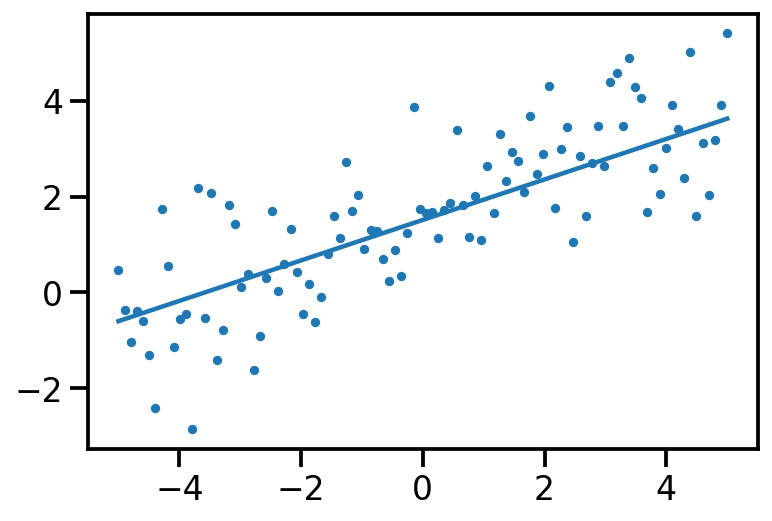

In [238]:
tf.random.set_seed(0)
th_sample, data_sample = model.sample()

plt.scatter(x[:, 0], data_sample, s=10)
plt.plot(x[:, 0], tf.reshape(x*th_sample[1] + th_sample[0], [-1]))
print(th_sample)

In [239]:
model.log_prob(th_sample, data_sample)

<tf.Tensor: shape=(), dtype=float32, numpy=-150.26591>

In [258]:
loc = tf.Variable([1.0, 1.0], dtype=tf.float32)
scale = tf.Variable([1.0, 1.0])

q_to_learn = tfd.Normal(loc=loc, scale=scale, name="q_theta_learn")

In [345]:
n_samples = 1000


loc = tf.Variable([1.0, 0.4], dtype=tf.float32)
scale = tfp.util.TransformedVariable([.7, .6], bijector=tfb.SoftClip(0.5, 1.0))
def loss():
    q_to_learn = tfd.Normal(loc=loc, scale=scale, name="q_theta_learn")
    q_1 = tfd.Normal(loc=[0.0,0.0], scale=[1.0, 1.0])
    sample_set = q_1.sample(n_samples)
    log_joint = tf.reduce_sum(model.log_prob(sample_set, data_sample))
    log_q = tf.reduce_sum(q_to_learn.log_prob(sample_set))
    return log_q - log_joint

In [352]:

trace6000 = tfp.math.minimize(loss_fn=loss, num_steps=6000, 
                  optimizer=tf.optimizers.Adam(0.0001))

In [347]:
loc

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1.4298061 , 0.84917635], dtype=float32)>

In [348]:
scale

<TransformedVariable: name=soft_clip, dtype=float32, shape=[2], fn="soft_clip", numpy=array([0.6512191, 0.5705266], dtype=float32)>

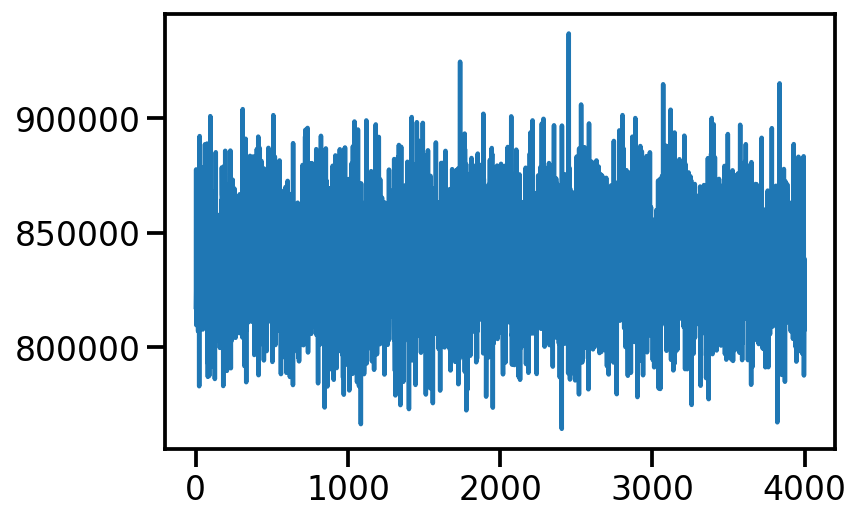

In [349]:
plt.plot(trace)

In [355]:
loc, th_sample, scale
#scale =  tfp.util.TransformedVariable([1., 1.], bijector=tfb.Exp())

(<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([2.0690155, 1.496477 ], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.5110626 , 0.42292204], dtype=float32)>,
 <TransformedVariable: name=soft_clip, dtype=float32, shape=[2], fn="soft_clip", numpy=array([0.5936036, 0.5403929], dtype=float32)>)

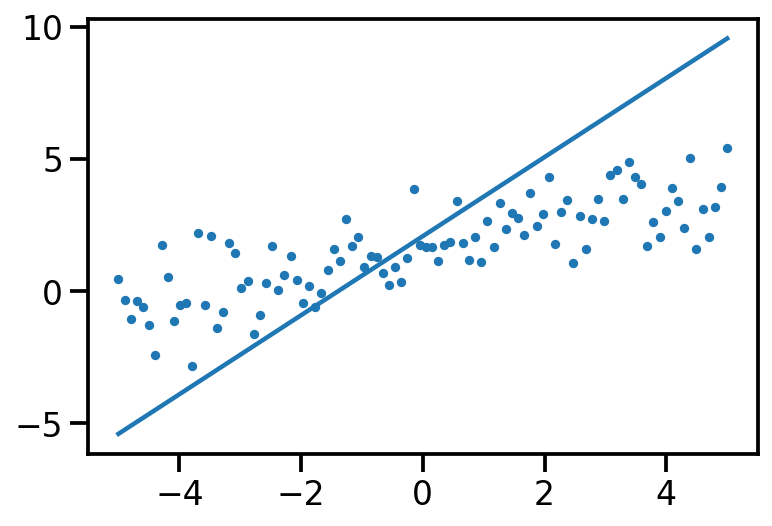

In [354]:
plt.scatter(x[:, 0], data_sample, s=10)
plt.plot(x[:, 0], tf.reshape(x*loc[1] + loc[0], [-1]))

In [359]:
loss_mc

<function __main__.loss_mc(loc, scale)>

In [372]:
loc = tf.Variable([1.0, 0.4], dtype=tf.float32)
scale = tfp.util.TransformedVariable([.7, .6], bijector=tfb.SoftClip(0.5, 1.0))

def loss_mc(loc, scale):
    q_to_learn = tfd.Normal(loc=loc, scale=scale, name="q_theta_learn")
    q_1 = tfd.Normal(loc=[0.0,0.0], scale=[1.0, 1.0])
    sample_set = q_1.sample(n_samples)
    log_joint = tf.reduce_sum(model.log_prob(sample_set, data_sample))
    log_q = tf.reduce_sum(q_to_learn.log_prob(sample_set))
    return log_q - log_joint

target_log_prob_fn = lambda th: model.log_prob((th, data_sample))




data_dim=2
qt_mean = tf.Variable(tf.random.normal([data_dim]))
qt_stddv = tfp.util.TransformedVariable(
    1e-4 * tf.ones([data_dim]), bijector=tfb.Softplus()
)


def factored_normal_variational_model():
    qt = yield tfd.Normal(loc=qt_mean, scale=qt_stddv, name="qt")


surrogate_posterior = tfd.JointDistributionCoroutineAutoBatched(
    factored_normal_variational_model
)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=target_log_prob_fn,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=100,
)

/Users/nipun/miniforge3/lib/python3.9/site-packages/tensorflow_probability/python/internal/vectorization_util.py:87: UserWarning: Saw Tensor seed Tensor("seed:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  warnings.warn(
/Users/nipun/miniforge3/lib/python3.9/site-packages/tensorflow_probability/python/internal/vectorization_util.py:87: UserWarning: Saw Tensor seed Tensor("seed:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which 

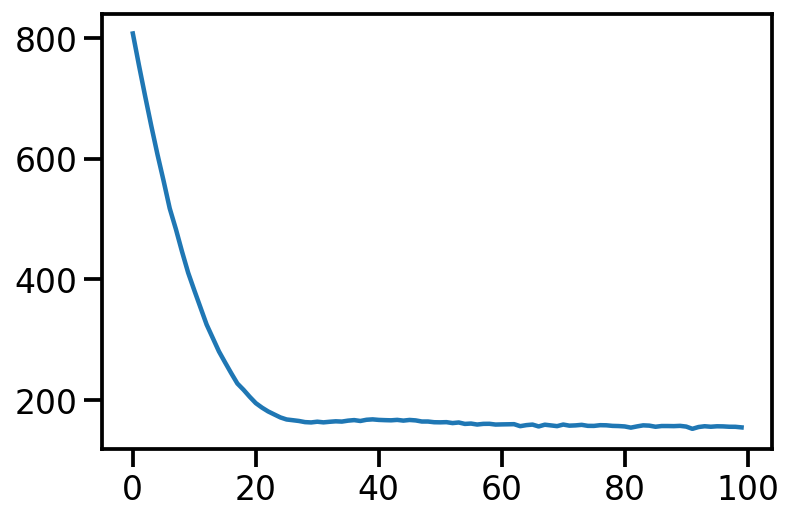

In [373]:
plt.plot(losses)

StructTuple(
  qt=<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.5720905, 0.4626296], dtype=float32)>
)

In [374]:
qt_mean, qt_stddv

(<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1.5777218 , 0.46246716], dtype=float32)>,
 <TransformedVariable: name=softplus, dtype=float32, shape=[2], fn="softplus", numpy=array([0.01456336, 0.01367522], dtype=float32)>)

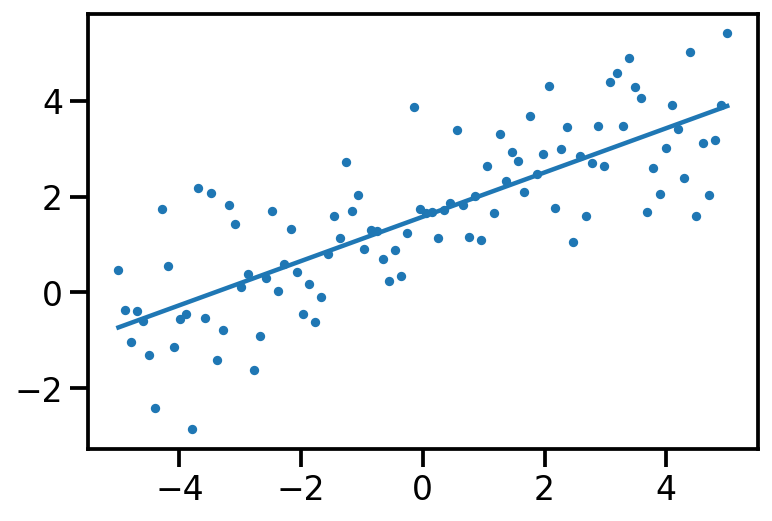

In [375]:
plt.scatter(x[:, 0], data_sample, s=10)
plt.plot(x[:, 0], tf.reshape(x*qt_mean[1] + qt_mean[0], [-1]))

In [393]:
post_samples = surrogate_posterior.sample(200)

post_samples.qt[0:5]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[1.5795265 , 0.500741  ],
       [1.5515635 , 0.46671686],
       [1.5585055 , 0.4617632 ],
       [1.5856469 , 0.44141397],
       [1.5763292 , 0.45420292]], dtype=float32)>

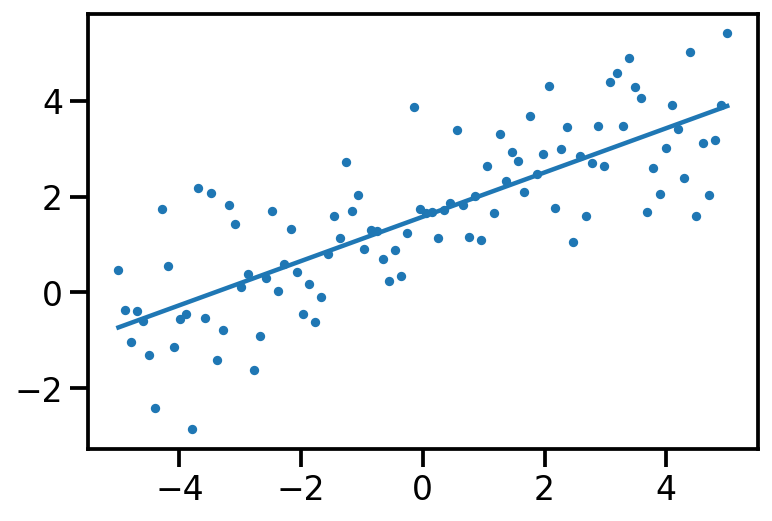

In [394]:
plt.scatter(x[:, 0], data_sample, s=10)

plt.plot(x[:, 0], tf.reshape(x*qt_mean[1] + qt_mean[0], [-1]))

References


- https://www.youtube.com/watch?v=HUsznqt2V5I
- https://www.youtube.com/watch?v=x9StQ8RZ0ag&list=PLISXH-iEM4JlFsAp7trKCWyxeO3M70QyJ&index=9
- https://colab.research.google.com/github/goodboychan/goodboychan.github.io/blob/main/_notebooks/2021-09-13-02-Minimizing-KL-Divergence.ipynb#scrollTo=gd_ev8ceII8q
- https://goodboychan.github.io/python/coursera/tensorflow_probability/icl/2021/09/13/02-Minimizing-KL-Divergence.html
